<a href="https://colab.research.google.com/github/Ujwal-EVA/Assignment-7/blob/main/EVA3_Session7_Batch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

Adding Image rotation 7 Deg


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
The Raw Model to Defined skeleton
1. Squeeze & Expand
2. Channel reduction (32--> 8)
3. Adding Max pooling
4. Adding Batch Normailisation
5. Adding Dropout to every block
6. Adding Global Average Pooling

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)

        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 20)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             432
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]              64
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Running Epoch

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2359839826822281 Batch_id=468 Accuracy=83.27: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]



Test set: Average loss: 0.0890, Accuracy: 9750/10000 (97.50%)

EPOCH: 1


Loss=0.03528904169797897 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s]



Test set: Average loss: 0.0532, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.07708278298377991 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0405, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.022614456713199615 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]



Test set: Average loss: 0.0363, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.029851391911506653 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]



Test set: Average loss: 0.0388, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.07816425710916519 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:20<00:00, 22.54it/s]



Test set: Average loss: 0.0269, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.03578484058380127 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]



Test set: Average loss: 0.0336, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


Loss=0.01741739921271801 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.03544370457530022 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:21<00:00, 21.35it/s]



Test set: Average loss: 0.0245, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.035884611308574677 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]



Test set: Average loss: 0.0295, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.021588938310742378 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]



Test set: Average loss: 0.0309, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.03504791483283043 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]



Test set: Average loss: 0.0242, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.007109181955456734 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.01020574476569891 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]



Test set: Average loss: 0.0262, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.15089964866638184 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)



## Plotting Results

Text(0.5, 1.0, 'Test Accuracy')

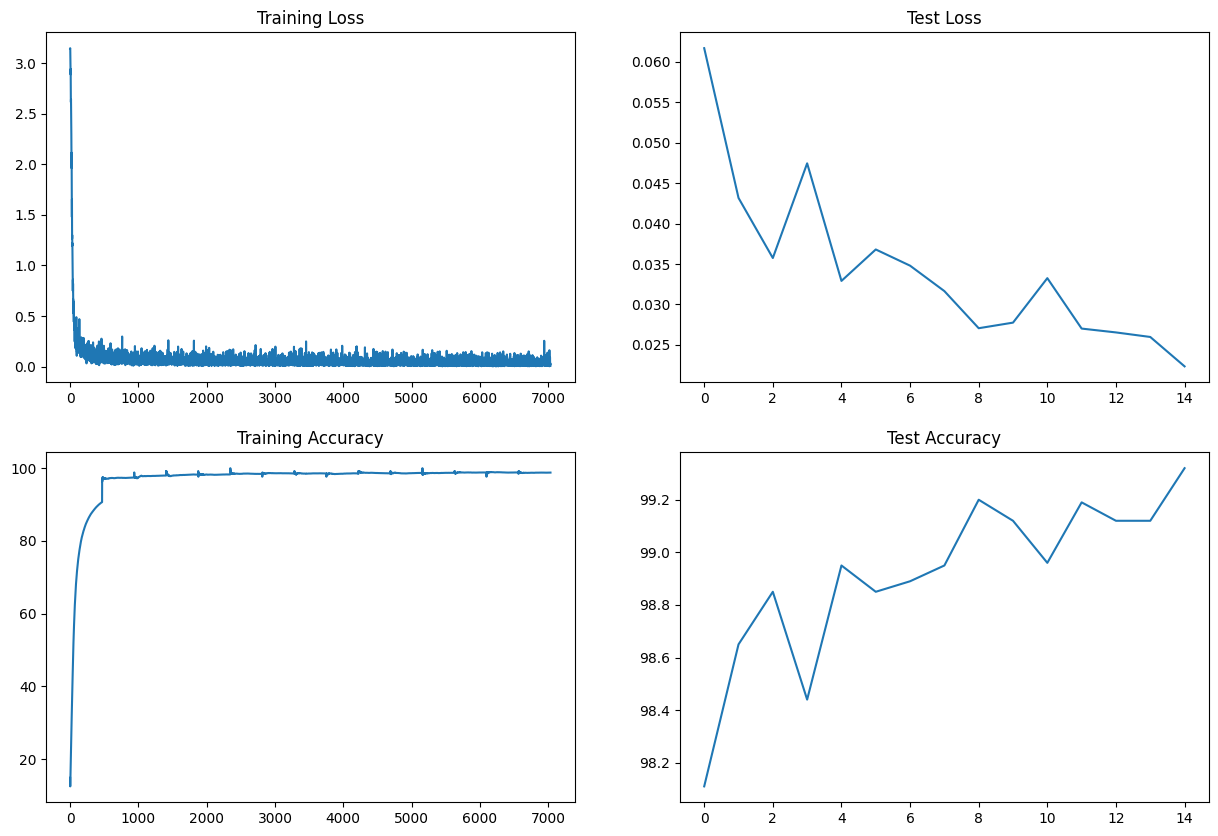

In [ ]:
train_losses
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")